# Genomic Data Clustering

#### DNA can be represented as a text sequence, with an alphabet that only has four letters - A (Adenosine), C (Cytosine), G (Guanine), and T (Thymine). The diversity of living organisms and their complex properties is hidden in their genomic sequences. One of the most exciting problems in modern science is to understand the organization of living matter by reading genomic sequences.

#### One distinctive message in a genomic sequence is a piece of text, called a gene. Genes can be oriented in the sequence in either the forward or backward directions. In the highest organisms (humans, for example), the notion of a gene is more complex.

#### It was one of the many great discoveries of the twentieth century, that biological information is encoded in genes through triplets of letters, called codons in the biological literature.

## Objective

#### In this exercise, we will see that it is possible to verify the validity of the discovery of three-letter codons, simply by performing unsupervised machine learning on the genetic sequence.

#### 1. First, the data is imported and prepared. Initially, the sequence, a single string, is split into non-overlapping substrings of length 300, and we may then count the combinations of the distinct 1, 2, 3, and 4-length sequences of base pairs that appear in each possible substring.
#### 2. PCA is performed to try to identify the internal structure of the data.
#### 3. Finally, if PCA reveals some internal structure then we'll apply Clustering techniques to the dataset.


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Data Prep

In [2]:
with open ("ccrescentus.fa", "r") as inputfile:
    data = inputfile.readlines()
    
geneticCode = ''

for line in data[1:]:
    geneticCode += line.strip()
    
aCount = geneticCode.count('a')
gCount = geneticCode.count('g')
tCount = geneticCode.count('t')
cCount = geneticCode.count('c')

print(geneticCode[0:30])
print('Test: only a, g, t, c?')
print(aCount + gCount + tCount + cCount == len(geneticCode))

gccgatagcctatgatccccggcaggcccg
Test: only a, g, t, c?
True


## Converting Text to Numerical Table

### Creating Frequency Tables
### Data Size
#### Knowing that our string has 305,100 characters and that we are checking words with a maximum of 4 letters, take the size of 300. It generates 1017 data points and allows for 75 4-letter words. It seems reasonable, but do feel free to change it and see the impact.

#### We clip the whole text into fragments of 300 letters, and calculate the frequencies of short words (of length 1 - 4) inside every fragment. This will give us a description of the text in the form of a numerical table. There will be four such tables for every short word length choice from 1 to 4.

#### As there are only four letters, there are four possible words of length 1 (singlets), 16 = 4^2 possible words of length 2 (duplets), 64 = 4^3 possible words of length 3 (triplets), and 256 = 4^4 possible words of length 4 (quadruplets).

In [3]:
size = 300
dataPoints = []

tempString = geneticCode

while len(tempString) > 0:
    dataPoints.append(tempString[0: size])
    tempString = tempString[size:]
    
print(dataPoints[0])

gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg


#### Creating a list from possible word combinations

In [4]:
import itertools

iterables = ['a', 't', 'c', 'g']
wordsDict = {}

for i in range(1, 5):
    words = []
    iterator = itertools.product(iterables, repeat = i)
    for word in iterator:
        s = ''
        for t in word:
            s += t
        words.append(s)
    wordsDict[i] = words
    
print(wordsDict[3])

['aaa', 'aat', 'aac', 'aag', 'ata', 'att', 'atc', 'atg', 'aca', 'act', 'acc', 'acg', 'aga', 'agt', 'agc', 'agg', 'taa', 'tat', 'tac', 'tag', 'tta', 'ttt', 'ttc', 'ttg', 'tca', 'tct', 'tcc', 'tcg', 'tga', 'tgt', 'tgc', 'tgg', 'caa', 'cat', 'cac', 'cag', 'cta', 'ctt', 'ctc', 'ctg', 'cca', 'cct', 'ccc', 'ccg', 'cga', 'cgt', 'cgc', 'cgg', 'gaa', 'gat', 'gac', 'gag', 'gta', 'gtt', 'gtc', 'gtg', 'gca', 'gct', 'gcc', 'gcg', 'gga', 'ggt', 'ggc', 'ggg']


## Dataframe for Frequency Matrix Construction 

In [5]:
freqTables = {}

for i in range(1, 5):
    df = pd.DataFrame(columns = wordsDict[i])
    
    for index, dataP in enumerate(dataPoints):
        df.loc[index] = np.zeros(len(wordsDict[i]))
        while len(dataP) > 0:
            left = dataP[0:i]
            df.loc[index, left] += 1
            dataP = dataP[i:]
    freqTables[i] = df
    
freqTables[3].head()

,aaa,aat,aac,aag,ata,att,atc,atg,aca,act,...,gtc,gtg,gca,gct,gcc,gcg,gga,ggt,ggc,ggg
0,0.0,0.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,1.0,1.0,8.0,3.0,2.0,4.0,6.0,3.0
1,1.0,0.0,3.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,2.0,4.0,10.0,3.0,1.0,3.0,9.0,2.0
2,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,...,4.0,1.0,0.0,2.0,12.0,6.0,0.0,6.0,7.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,6.0,6.0,4.0,0.0,8.0,7.0,2.0
4,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,...,7.0,1.0,0.0,4.0,5.0,4.0,2.0,3.0,5.0,2.0


# Principal Component Analysis

#### We calculate frequency tables to see if certain combinations happen more frequently (and more frequently together), and thus might be more meaningful, than others.

#### The first step to running PCA is to normalize the data across columns.
#### We do this to have the same averages and dispersions across the data, which is an important concept of both PCA and K-means, as they are distance-based algorithms.
#### The StandardScaler function is used to achieve this.



In [6]:
normFreqTables = {}

for i in range(1, 5):
    data = freqTables[i]
    data = StandardScaler(copy = True, with_mean = True, with_std = True).fit_transform(data)
    normFreqTables[i] = pd.DataFrame(data, columns = wordsDict[i])

print(normFreqTables[2].loc[:, 'gt'].mean())
print(normFreqTables[2].loc[:, 'gt'].std())

-7.352361918240343e-17
1.0004920049498138


In [7]:
pca = PCA(n_components = 2)
pCompTables = {}

for i in range(1, 5):
    pca.fit(normFreqTables[i])
    pComponents = pca.transform(normFreqTables[i])
    pCompTables[i] = pd.DataFrame(pComponents[:, [0, 1]], columns = ['pc1', 'pc2'])
    print('Explained variance for ' + str(i) + ' letters: ' + str(pca.explained_variance_ratio_.sum()))
    
print(pCompTables[2].head())

Explained variance for 1 letters: 0.7489363490534281
Explained variance for 2 letters: 0.22791121047456636
Explained variance for 3 letters: 0.3167020193818014
Explained variance for 4 letters: 0.029341120814898276
        pc1       pc2
0 -0.999038 -0.458880
1 -0.087831 -0.887089
2  1.171020  0.322751
3  0.550408  1.078163
4  0.063875  1.700023


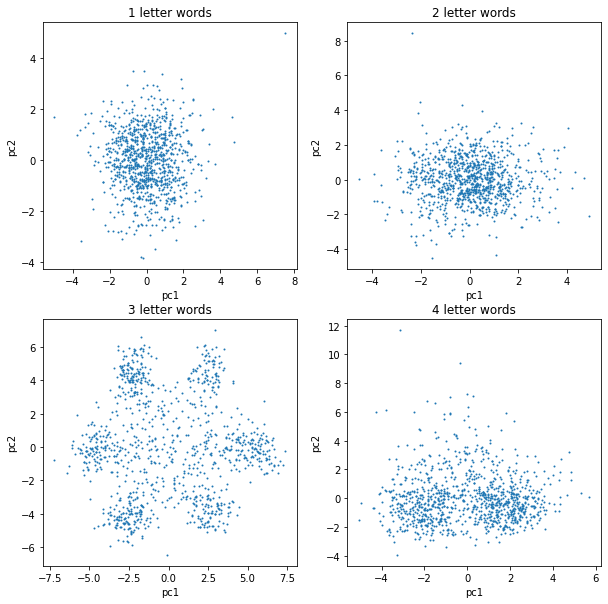

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    x = pCompTables[i].loc[:,'pc1']
    y = pCompTables[i].loc[:,'pc2']
    plt.scatter(x, y, s = 1)
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.title(str(i) + ' letter words')

plt.show()

#### From the plots, we can clearly see that 3 letters generates identifiable visual relations between data points in the first two principal components. These 3 letter words are called codons in biology.

#### We can identify 6 distinct poles, or centroids in the graph. If the genetic information is coded in 3-letter words, each of these clusters has similar distributions of frequencies of these words.


# Clustering

In [9]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(normFreqTables[3])

KMeans(n_clusters=7)

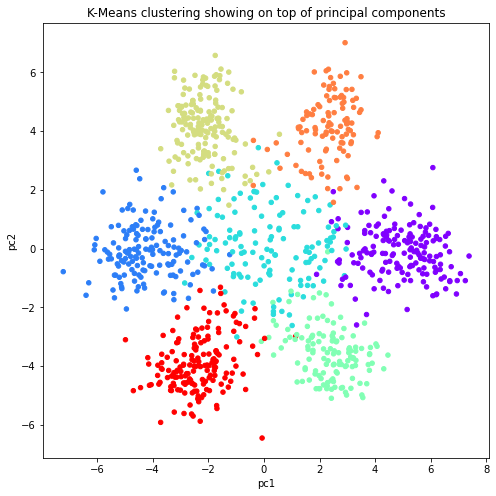

In [10]:
plt.figure(figsize = (8, 8))
x = pCompTables[3].loc[:,'pc1']
y = pCompTables[3].loc[:,'pc2']
plt.scatter(x, y, s = 20, c = kmeans.labels_, cmap = 'rainbow')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('K-Means clustering showing on top of principal components')
plt.show()

#### Unsupervised Learning through Clustering (K-means Clustering) and Dimensionality Reduction (PCA) has allowed us to visualize, validate, and provide supporting evidence for the biological discovery that the DNA genetic sequence is organized into three-letter words called codons, which are responsible for the amino acids and proteins that are produced by living cells.